<h2>Movie Recommender based on User Rating</h2>

Recommender systems are widely used in product recommendations such as recommendations of music, movies, books, news, research articles, restaurants, etc. 

There are two popular methods for building recommender systems:
- Collaborative filtering 
- Content-based filtering

**Collaborative filtering :**
The collaborative filtering method predicts (filters) the interests of a user on a product by collecting preferences information from many other users (collaborating). 
The assumption behind the collaborative filtering method is that if a person P1 has the same opinion as another person P2 on an issue, P1 is more likely to share P2’s opinion on a different issue than that of a randomly chosen person.

**Content-based filtering method :**
Content-based filtering method utilizes product features/attributes to recommend other products similar to what the user likes, based on other users’ previous actions or explicit feedback such as rating on products.

**Dataset Source :**
https://www.kaggle.com/prajitdatta/movielens-100k-dataset

**Problem statement :**

To build a Movie Recommender System based on the Customer ratings. 

The n number of Movie are recommended based on the similarity of the movie ratings.

**Data Description :**

MovieLens datasets were collected by the GroupLens Research Project at the University of Minnesota.
This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)


<h3>Importing the dataset and necessary libraries : </h3>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline 

import scipy.stats
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read All Dataset with assign column 

# 1. User's Data
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('data/u.user', sep='|', names=u_cols,encoding='latin-1', parse_dates=True) 

# 2. Rating Data
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('data/u.data', sep='\t', names=r_cols,encoding='latin-1')

# 3.Movies Data
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('data/u.item', sep='|', names=m_cols, usecols=range(5),encoding='latin-1')
movies['release_date'] = pd.to_datetime(movies['release_date'])

The three datasets which have been used are:

**u.user :**
The user’s data file which contains 943 rows and 5 columns. 
The features are : 'user_id', 'age', 'sex', 'occupation', and 'zip_code' 

**u.data :**
The rating’s data file which contain 100000 rows and 4 columns.
The features are : 'user_id', 'movie_id', 'rating', and 'unix_timestamp'

**u.item :**
The movie’s data file which contains 1682 rows and 5 columns.
The features are : 'movie_id', 'title', 'release_date', 'video_release_date', and 'imdb_url'

---

In [3]:
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [4]:
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [5]:
movies

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998-02-06,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),1998-02-06,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),1998-01-01,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


---

<h3>Exploratory Data Analysis</h3>

In [6]:
print("Ratings Data :\n")
print("Rating Values   :",sorted(ratings['rating'].unique()))
print("Highest Rating  :",ratings['rating'].max())
print("Lowest Rating   :",ratings['rating'].min())
print("Average Rating  :",round(ratings['rating'].mean(),4))

Ratings Data :

Rating Values   : [1, 2, 3, 4, 5]
Highest Rating  : 5
Lowest Rating   : 1
Average Rating  : 3.5299


In [7]:
print("Ratings Data :\n")
print("Total Number of Movies :",len(ratings['movie_id'].unique()))
print("Total Number of Users :",len(ratings['user_id'].unique()))

Ratings Data :

Total Number of Movies : 1682
Total Number of Users : 943


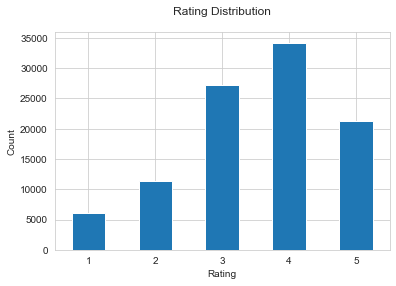

In [8]:
ratings['rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [9]:
df = pd.merge(ratings,movies,on='movie_id')
df.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url
0,196,242,3,881250949,Kolya (1996),1997-01-24,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
1,63,242,3,875747190,Kolya (1996),1997-01-24,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
2,226,242,5,883888671,Kolya (1996),1997-01-24,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
3,154,242,3,879138235,Kolya (1996),1997-01-24,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
4,306,242,5,876503793,Kolya (1996),1997-01-24,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)


In [10]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [11]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [12]:
movie_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
movie_ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [13]:
movie_ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
movie_ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


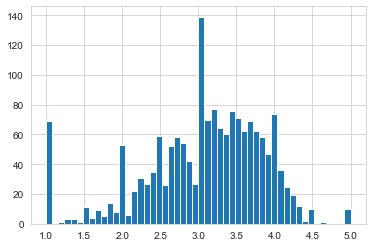

In [14]:
movie_ratings['rating'].hist(bins=50)

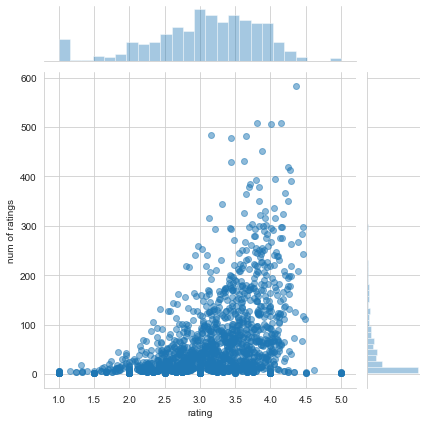

In [15]:
sns.jointplot(x='rating',y='num of ratings',data=movie_ratings,alpha=0.5)

We can infer from the jointplot that the movies with extreme ratings (1 star and 5 star) have few number of ratings. When more people review a movie, the ratings fall inbetween the range of 2.5 and 4.5

In [16]:
movie_ratings[movie_ratings['num of ratings'] > 500]

,rating,num of ratings
title,,
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Star Wars (1977),4.358491,583


It was found that `Star Wars` is a successful movie with high number of ratings and a very good overall rating of 4.3

<h3>Data Preprocessing</h3>

In [17]:
#Selecting Required features

movie_ratings = pd.merge(movies, ratings)
data = pd.merge(movie_ratings,users)
data.head(5)

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


In [18]:
print("Number of Unique Movies :",len(data['title'].unique()))
print("Number of Unique Users :",len(data['user_id'].unique()))

Number of Unique Movies : 1664
Number of Unique Users : 943


<h3> Building a m * n matrix using pivot_table </h3>
<ul>
    <li>n - number of Users ( rows ) </li>
    <li>m - number of Movie  ( columns ) </li>
</ul>


In [19]:
matrix = data.pivot_table(index='user_id', columns='title', values='rating')
matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
matrix.shape

(943, 1664)

**Pearson correlation coefficient**

Correlation is a technique for investigating the relationship between two quantitative, continuous variables, for example, age and blood pressure. Pearson's correlation coefficient (r) is a measure of the strength of the association between the two variables.

Values always range between -1 (strong negative relationship) and +1 (strong positive relationship).

<img src = "https://cdn1.byjus.com/wp-content/uploads/2019/06/word-image28.png">

In [21]:
def pearson(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denomenator = np.sqrt((np.sum((x - x_mean)**2)*(np.sum((y - y_mean)**2))))
    return numerator / denomenator

<h3>Illustration on finding the pearson correlation coefficient</h3>

1. The ratings given by each user for a particular movie is selected from the matrix (x)
2. The ratings given by each user for another movie is selected from the matrix (y)
3. The pearson coefficient is found by calling the function which was declared above. 

In [22]:
matrix["Toy Story (1995)"]

user_id
1      5.0
2      4.0
3      NaN
4      NaN
5      4.0
      ... 
939    NaN
940    NaN
941    5.0
942    NaN
943    NaN
Name: Toy Story (1995), Length: 943, dtype: float64

In [23]:
matrix["101 Dalmatians (1996)"]

user_id
1      2.0
2      NaN
3      NaN
4      NaN
5      2.0
      ... 
939    NaN
940    NaN
941    NaN
942    NaN
943    NaN
Name: 101 Dalmatians (1996), Length: 943, dtype: float64

In [24]:
pearson(matrix["101 Dalmatians (1996)"], matrix["Toy Story (1995)"])

0.10085674039680688

There is a positive correlation between "101 Dalmatians (1996)", and "Toy Story (1995)". However, the relationship is not strong enough.

<h3>Another illustration</h3>

In [25]:
matrix["Beauty and the Beast (1991)"]

user_id
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
       ..
939   NaN
940   NaN
941   NaN
942   NaN
943   NaN
Name: Beauty and the Beast (1991), Length: 943, dtype: float64

In [26]:
pearson(matrix["Jurassic Park (1993)"], matrix["Toy Story (1995)"])

0.18741114002275608

It can be found that "Jurassic Park (1993)" has a higher correlation with  "Toy Story (1995)" than 101 Dalmatians (1996)

<h3>Recommender system : </h3>
<ol>
    <li>Find the pearson coefficient value between the selected Movie and all other Movies.</li>
    <li>Neglet NaN values.</li>
    <li>Create a list containing the coefficient value and sort it in descending order.</li>
    <li>The number of recommendations are given based on the mentioned number.</li>

In [27]:
def recommend(movie, matrix, n):
    """
    movie  : Movie title
    matrix : Matrix name
    n      : Number of recommendations
    rec    : List containing the recommendations
    """
    rec=[]
    
    for num in matrix.columns:
        """
        Since the matrix has 1664 columns, this loop runs 1664 times
        If the given movie matches with the movie in matrix, skip and move to the next iteration (to avoid finding the pearson coefficient between two same items). 
        Find the pearson correlation coefficient between the current movie in the loop and the given movie.
        If the correlation value is NaN, skip and move to the next iteration.
        Else, append the correlation value in the list named 'rec' along with the movie name. Continue this step to find the correlation coefficent value between given movie and each movie.
        Sort the list on descending order.
        Return the list with the number of elements up to the specified number (n)
        """
        if num == movie:
            continue 
            
        cor = pearson(matrix[movie], matrix[num])
        
        if np.isnan(cor):
            continue
        
        else:
            rec.append((num, cor))
            
    rec.sort(key= lambda x: x[1], reverse=True)
    return rec[:n]

In [28]:
movie = (input("Enter Movie Name : "))
n = int(input("Enter number of recommendations : "))

recommendations = recommend(movie, matrix, n)

print("\nRecommended Movies :")
for i in recommendations:
    print(i[0])

Enter Movie Name : Toy Story (1995)
Enter number of recommendations : 10

Recommended Movies :
Beauty and the Beast (1991)
Aladdin (1992)
Craft, The (1996)
Transformers: The Movie, The (1986)
Lion King, The (1994)
That Thing You Do! (1996)
Raiders of the Lost Ark (1981)
Apollo 13 (1995)
Jurassic Park (1993)
E.T. the Extra-Terrestrial (1982)



---

<h3>Evaluating the model</h3>

In [29]:
print(pearson(matrix["Beauty and the Beast (1991)"], matrix["Toy Story (1995)"]))
print(pearson(matrix["Aladdin (1992)"], matrix["Toy Story (1995)"]))
print(pearson(matrix["Craft, The (1996)"], matrix["Toy Story (1995)"]))

0.24696605700155527
0.23493891394144065
0.2129759374197294


It can be seen that the ratings of "Beauty and the Beast (1991)" is similar to that of "Toy Story (1995)". Also, since both are animated films, we can say that our model is working correctly.

Toy Story is a 1995 American <u>computer-animated buddy comedy film</u> produced by Pixar Animation Studios and released by Walt Disney Pictures. 

<b>Most of the recommended movies (<i> Beauty and the Beast, Aladdin, Lion King, etc. </i>) are <u>animated films</u>. Thus we can say that our recommender system is working correctly.</b>


---
<h2>KNN Item-Based Collaborative Filtering</h2>

Collaborative filtering systems use the actions of users to recommend other movies. In general, they can either be user-based or item-based. Item based approach is usually preferred over user-based approach. User-based approach is often harder to scale because of the dynamic nature of users, whereas items usually don’t change much, and item based approach often can be computed offline and served without constantly re-training.

To implement an item based collaborative filtering, KNN is a perfect go-to model and also a very good baseline for recommender system development.

kNN is a machine learning algorithm to find clusters of similar users based on common movie ratings, and make predictions using the average rating of top-k nearest neighbors.

We convert our table to a 2D matrix, and fill the missing values with 0 (since we will calculate distances between rating vectors). Since 0 is also a rating value, we will add 5 to the actual rating values. 
So a rating of 0 becomes 5 , a rating of 1 becomes 6, and a rating of 2 becomes 7. 


In [30]:
knn_matrix = data.pivot_table(index='title',columns='user_id',values='rating').fillna(0)
knn_matrix

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-900 (1994),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),5.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187 (1997),0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Guns II (1990),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
"Young Poisoner's Handbook, The (1995)",0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zeus and Roxanne (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
knn_matrix[0:1664] += 5
knn_matrix

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1-900 (1994),5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
101 Dalmatians (1996),7.0,5.0,5.0,5.0,7.0,5.0,5.0,5.0,5.0,5.0,...,7.0,5.0,5.0,7.0,9.0,5.0,5.0,5.0,5.0,5.0
12 Angry Men (1957),10.0,5.0,5.0,5.0,5.0,9.0,9.0,5.0,5.0,10.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
187 (1997),5.0,5.0,7.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Guns II (1990),5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,8.0
"Young Poisoner's Handbook, The (1995)",5.0,5.0,5.0,5.0,5.0,5.0,8.0,5.0,5.0,5.0,...,5.0,5.0,10.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Zeus and Roxanne (1997),5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


A Pivot Table is used to summarise, sort, reorganise, group, count, total or average data stored in a table. It allows us to transform columns into rows and rows into columns. It allows grouping by any field (column), and using advanced calculations on them.

---

<h3>Converting the matrix to CSR Matrix (Compressed Sparse Row) </h3>

The compressed sparse row (CSR) or compressed row storage (CRS) or Yale format represents a matrix M by three (one-dimensional) arrays, that respectively contain nonzero values, the extents of rows, and column indices. It is similar to COO, but compresses the row indices, hence the name.

In [32]:
sparse_matrix = csr_matrix(knn_matrix.values)

---

<h3>Creating an instance of KNN :</h3>

We use unsupervised algorithms with sklearn.neighbors.

The algorithm we use to compute the nearest neighbors is “brute”.

We specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors.

Finally, we fit the model.

In [33]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

### Fitting the model with scipy sparse matrix

In [34]:
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

<h3>Implementing KNN Algorithm:</h3>


In this step, the kNN algorithm measures distance to determine the “closeness” of instances. It then classifies an instance by finding its nearest neighbors, and picks the most popular class among the neighbors

In [35]:
def model_test(movie_name, matrix ,no_of_recommendations):
    """
    This function is used to test the KNN model which was developed. 
    Parameter
    -------
    movie_name: str, wathched/favorite movie
    matrix: DatFrame, created by the pivot_table() funtion
    no_of_recommendations: int, number of recommended movie have to be displayed
    """
    for idx, val in enumerate(matrix.index):
        if val == movie_name:
            index = idx
            distances, indices = model_knn.kneighbors(matrix.iloc[index, :].values.reshape(1,-1),
                                                      n_neighbors = no_of_recommendations+1)
            for i in range(0, len(distances.flatten())):
                if i == 0:
                    print('Recommendations for {0}:\n'.format(matrix.index[index]))
                else:
                    print('{0}: {1}'.format(i, matrix.index[indices.flatten()[i]]))

In [36]:
movie = input("Enter Movie name : ")
n = int(input("Enter number of recommendations : "))

model_test(movie, knn_matrix, n)


Enter Movie name : Lion King, The (1994)
Enter number of recommendations : 10
Recommendations for Lion King, The (1994):

1: Aladdin (1992)
2: Beauty and the Beast (1991)
3: Cinderella (1950)
4: Pocahontas (1995)
5: Dumbo (1941)
6: Homeward Bound: The Incredible Journey (1993)
7: Pinocchio (1940)
8: Mrs. Doubtfire (1993)
9: Snow White and the Seven Dwarfs (1937)
10: Fox and the Hound, The (1981)


<h3>Evaluating the recommendations</h3>

In [37]:
print(pearson(matrix["Lion King, The (1994)"], matrix["Aladdin (1992)"]))
print(pearson(matrix["Lion King, The (1994)"], matrix["Beauty and the Beast (1991)"]))
print(pearson(matrix["Lion King, The (1994)"], matrix["Cinderella (1950)"]))

0.38334129772410025
0.3649675448219244
0.2744713050274766


The Lion King comes under the following genres: Animation, Children's film, Musical, Adventure

The best recommendation (Aladdin) comes under these genres: Animation, Children's film, Musical, Romance

<b>Since the given movie and the best recommendation falls under similar genres, we can say that our recommender is working correctly. They have the highest correlation among all other movies.</b>
    
<b>Most of the recommended movies (<i> Beauty and the Beast (1991) , Cinderella (1950), Pocahontas (1995), etc. </i>) are <u>animated  films</u>. 
    
Thus we can say that our recommender system is working correctly.</b>

---